# UNSUPERVISED LEARNING ON CREDIT SCORE DATA

**OBJECTIVE: CLUSTER DATA TO IDENTIFY POTENTIAL PATTERNS RELATED TO CREDIT SCORES**

In [72]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import silhouette_score, calinski_harabasz_score
from sklearn.decomposition import PCA
from sklearn.compose import ColumnTransformer





In [73]:
df = pd.read_csv('C:\\Users\\rajih\\OneDrive\\Documents\\GitHub\\E-commerce_Promotion_Analysis\\Datasets\\feature_library.csv')
df.shape

(100000, 62)

Selecting relevant columns

In [74]:
num_columns = df.select_dtypes(include=['int64', 'float', 'uint8']).columns
selected_columns = list(num_columns) + ['Credit_Score']
df2 = df[selected_columns]
zscore_columns = [col for col in df2.columns if 'Zscore' in col or 'zscore' in col]

#drop outlier test 
df2 = df2.drop(columns=zscore_columns, errors='ignore')
print(f"Dropped columns: {zscore_columns}")

Dropped columns: ['income_zscore', 'Delay_Zscore']


Preprocess for Kmeans

In [75]:
#need to encode credit_score
df2 = pd.get_dummies(df2, columns=['Credit_Score'], prefix='Credit_Score')

In [76]:
# scale
X = df2.values
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

Find Optimal K

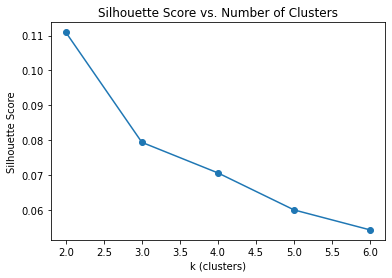

In [77]:
k_range = range(2, 7)  
sil_scores = []

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(X_scaled)
    sil = silhouette_score(X_scaled, labels)
    sil_scores.append(sil)

# Plot Silhouette Scores
plt.figure(figsize=(6,4))
plt.plot(k_range, sil_scores, marker='o')
plt.title("Silhouette Score vs. Number of Clusters")
plt.xlabel("k (clusters)")
plt.ylabel("Silhouette Score")
plt.show()

In [78]:
# Identify best k ( highest silhouette)
best_k = k_range[np.argmax(sil_scores)]
print(f"Best k by silhouette score = {best_k} (Score={max(sil_scores):.4f})")

Best k by silhouette score = 2 (Score=0.1109)


Fitting K-Mean & adding cluster labels back

In [79]:
#Fit K-Means with best_k
kmeans_final = KMeans(n_clusters=best_k, random_state=42)
labels_final = kmeans_final.fit_predict(X_scaled)

# Add cluster labels to df2
df2["Cluster"] = labels_final



Cluster Means

In [80]:
# Check cluster means
cluster_means = df2.groupby("Cluster").mean()
print("\nCluster Means:\n", cluster_means)


Cluster Means:
                Age  Annual_Income  Monthly_Inhand_Salary  Num_Bank_Accounts  \
Cluster                                                                       
0        29.841512   34785.740617            2823.137295           7.212323   
1        36.151965   64394.107825            4794.844102           4.118456   

         Num_Credit_Card  Interest_Rate  Num_of_Loan  Delay_from_due_date  \
Cluster                                                                     
0               6.851063      22.023458     5.621338            31.546271   
1               4.661617       9.265887     2.036411            13.551130   

         Num_of_Delayed_Payment  Changed_Credit_Limit  ...  \
Cluster                                                ...   
0                     17.295289             13.293781  ...   
1                     10.599787              7.543075  ...   

         Credit_Mix_Standard  Payment_of_Min_Amount_Yes  \
Cluster                                          

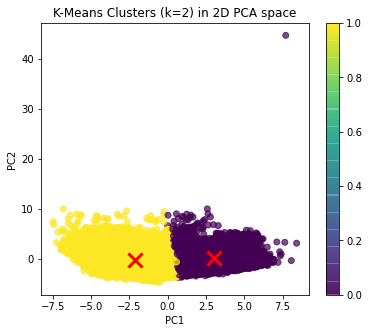

    Age  Annual_Income  Monthly_Inhand_Salary  Num_Bank_Accounts  \
0  23.0          19114            1824.843333                  3   
1  23.0          19114            3093.745000                  3   
2  23.0          19114            3093.745000                  3   
3  23.0          19114            3093.745000                  3   
4  23.0          19114            1824.843333                  3   
5  23.0          19114            3093.745000                  3   
6  23.0          19114            1824.843333                  3   
7  23.0          19114            1824.843333                  3   
8  28.0          34847            3037.986667                  2   
9  28.0          34847            3037.986667                  2   

   Num_Credit_Card  Interest_Rate  Num_of_Loan  Delay_from_due_date  \
0                4              3            4                    3   
1                4              3            4                   -1   
2                4              3     

In [ ]:
# PCA for 2D Visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Plot clusters in 2D PCA space
plt.figure(figsize=(6,5))
scatter = plt.scatter(X_pca[:,0], X_pca[:,1], c=labels_final, cmap="viridis", alpha=0.7)
plt.colorbar(scatter)
plt.title(f"K-Means Clusters (k={best_k}) in 2D PCA space")
plt.xlabel("PC1")
plt.ylabel("PC2")

# Plot cluster centers in PCA space (transform original centers)
centers = kmeans_final.cluster_centers_
centers_pca = pca.transform(centers)
plt.scatter(centers_pca[:,0], centers_pca[:,1],
            marker='x', s=200, linewidths=3, color='r', zorder=10)
plt.show()

# 8. Inspect final results
print(df2.head(10))


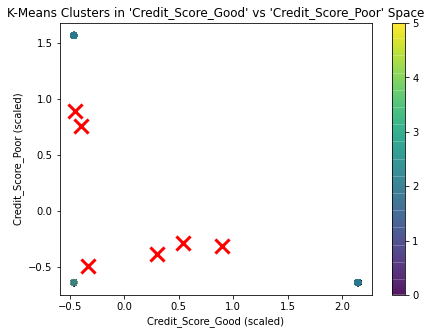

In [ ]:
import matplotlib.pyplot as plt

#  Get column indices for 'Credit_Score_Good' and 'Credit_Score_Poor' in df2
good_col_idx = df2.columns.get_loc("Credit_Score_Good")
poor_col_idx = df2.columns.get_loc("Credit_Score_Poor")

# Extract these two dimensions from the scaled data
X_good = X_scaled[:, good_col_idx]
X_poor = X_scaled[:, poor_col_idx]

# 3. Plot the clusters using these two features
plt.figure(figsize=(7, 5))
scatter = plt.scatter(X_good, X_poor, c=labels, cmap='viridis', alpha=0.7)
plt.colorbar(scatter)
plt.title("K-Means Clusters in 'Credit_Score_Good' vs 'Credit_Score_Poor' Space")
plt.xlabel("Credit_Score_Good (scaled)")
plt.ylabel("Credit_Score_Poor (scaled)")

# 4. (Optional) Plot cluster centers
#    The cluster centers are in kmeans.cluster_centers_, so we also need
#    their 'good_col_idx' and 'poor_col_idx' dimensions.
centers_good = kmeans.cluster_centers_[:, good_col_idx]
centers_poor = kmeans.cluster_centers_[:, poor_col_idx]
plt.scatter(centers_good, centers_poor,
            marker='x', s=200, linewidths=3, color='r', zorder=10)

plt.show()
